# Quantum Computing Demonstration



### Shor's Algorithm Simulation

Much of the ideas and structure of the code for this section were adapted from the Qiskit Online Textbook on Shor's Algorithm
https://qiskit.org/textbook/ch-algorithms/shor.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

For this example we constructed a circuit for:

N = 63 = 9*7

a = 2, which is relatively prime to N

Q = 4096

q = 12

Text(0.5, 1.0, 'Graph of 2^x mod 63')

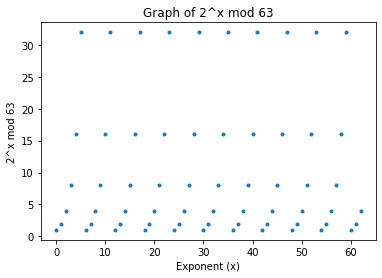

In [2]:
N = 63
a = 2

x = range(63)

plt.plot(x,[(2**i)%63 for i in x], linestyle='none', marker='.', mew=1)
plt.xlabel('Exponent (x)')
plt.ylabel('2^x mod 63')
plt.title('Graph of 2^x mod 63')

In [3]:
#builds a quantum circuit which conditionally multiplies by 2^power mod 63
def c_2times_mod63(power):
    
    U = QuantumCircuit(6)
    
    #multiplication by 2 mod 63 is very simple logically, since the multiplication
    #can be separated into operations of each bit
    for i in range(power):
        U.swap(5,4)
        U.swap(4,3)
        U.swap(3,2)
        U.swap(2,1)
        U.swap(1,0)
    
    U = U.to_gate()
    U.name = "2^%i mod 63" % (power)
    
    #adds a control line to the gate
    c_U = U.control()
    
    return c_U

C:\Users\Joon-hee\AppData\Roaming\Python\Python37\site-packages\qiskit\visualization\circuit_visualization.py:347: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  image.show()


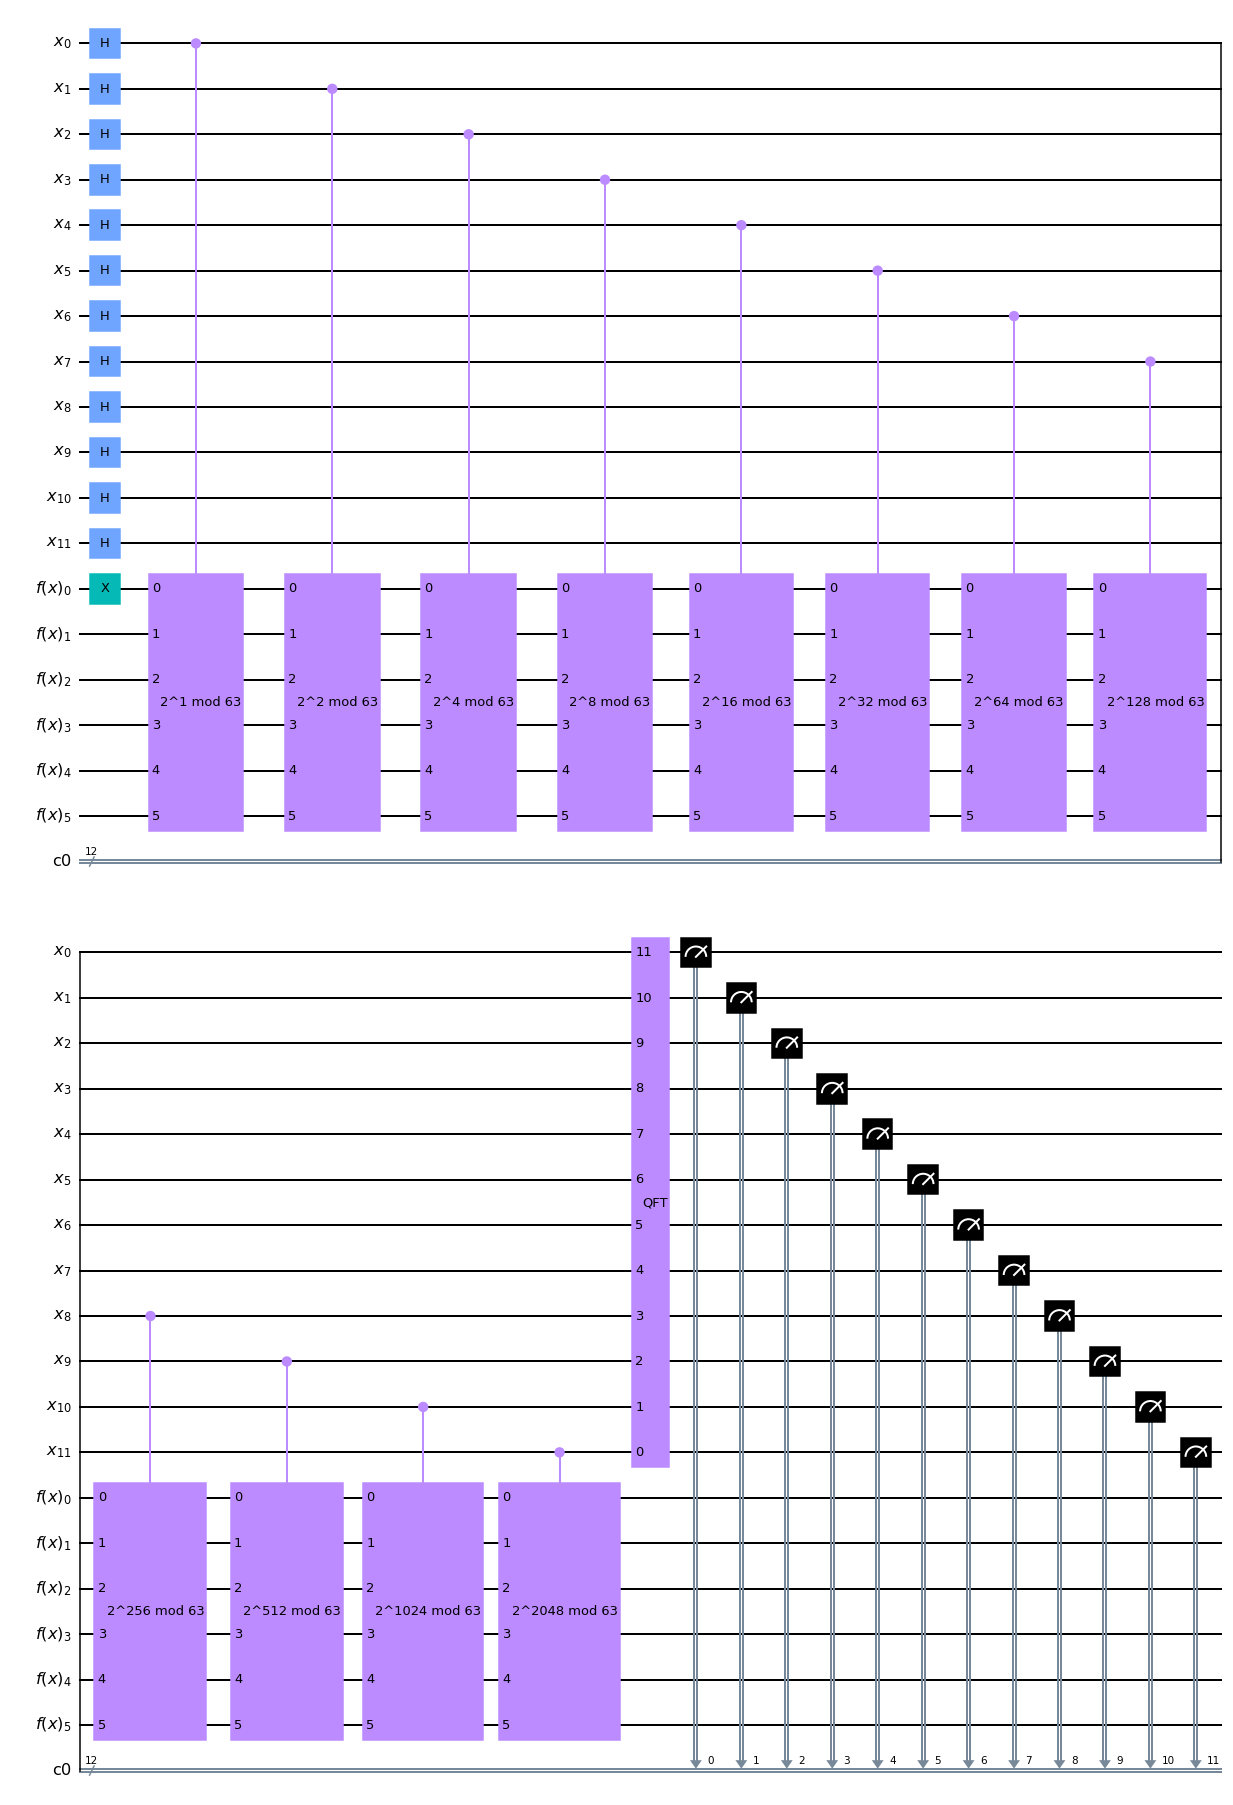

In [4]:
#18 qubits, 12 to hold x and 6 to hold f(x)
#11 classical bits to hold the measurement
qc = QuantumCircuit(QuantumRegister(12,'x'),QuantumRegister(6,'f(x)'),ClassicalRegister(12))

#apply Hadamard gate to each of the qubits that represent x
#result is uniform superposition
for i in range(12):
    qc.h(i)

#the qubits that represent f(x) start in state 0, change the state
#to 1, so that we can simply multiply mod 63
qc.x(12)

#perform controlled multiplication by the values 2^(2^i) on the f(x) register
for i in range(12):
    qc.append(c_2times_mod63(2**i), [i] + [12 + j for j in range(6)])

#apply QFT to the qubits that represent x
qc.append(QFT(12, name='QFT'), [11 - i for i in range(12)])

#perform measurement of the first register
qc.measure(range(12), range(12))

qc.draw('mpl',interactive=True)

Text(0.5, 1.0, "Results of 5000 runs of Shor's")

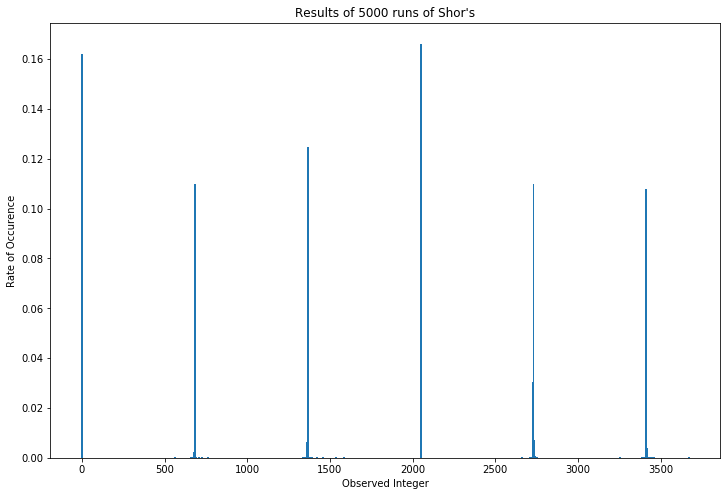

In [5]:
#use a backend that simulates quantum computer on classical computer
#provided by IBM
backend = Aer.get_backend('qasm_simulator')

#perform the calculation 5000 times
results = execute(qc, backend, shots=5000).result()
counts = results.get_counts()
plt.figure(figsize=(12,8))
plt.bar([int(k,2) for k in counts], [counts[k]/5000 for k in counts], width=12)
plt.xlabel('Observed Integer')
plt.ylabel('Rate of Occurence')
plt.title('Results of 5000 runs of Shor\'s')

Text(0.5, 1.0, "Results of 5000 runs of Shor's")

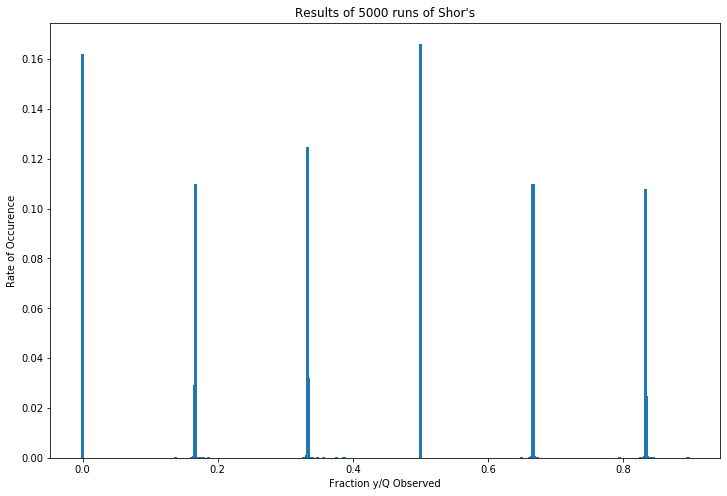

In [6]:
plt.figure(figsize=(12,8))
plt.bar([int(k,2)/4096 for k in counts], [counts[k]/5000 for k in counts], width=.005)
plt.xlabel('Fraction y/Q Observed')
plt.ylabel('Rate of Occurence')
plt.title('Results of 5000 runs of Shor\'s')

In [7]:
#translate the most frequently observed outcomes into the fraction it represents
good_fractions = [Fraction(int(k,2),2**12) for (k,v) in counts.items() if v > 500]
print([str(i.numerator) + '/' + str(i.denominator) for i in good_fractions])

#take the closest fraction approximation with denominator less than or equal to N
approx = [f.limit_denominator(63) for f in good_fractions]
print([str(i.numerator) + '/' + str(i.denominator) for i in approx])

['0/1', '683/4096', '1365/4096', '1/2', '2731/4096', '3413/4096']
['0/1', '1/6', '1/3', '1/2', '2/3', '5/6']


In [8]:
#get the denominators
denominators = np.array([f.denominator for f in approx])
print(denominators)

[1 6 3 2 3 6]


In [9]:
#take only the even denominators
even_denominators = denominators[(denominators%2==0)]
print(even_denominators)

[6 2 6]


In [10]:
#calculate the modular exponent a^(r/2)
modular = [int((2**(i/2))%63) for i in even_denominators]
print(modular)

#use those to calculate a^(r/2)+1 and a^(r/2)-1
pm_1 = [(i+1,i-1) for i in modular]
print(pm_1)

[8, 2, 8]
[(9, 7), (3, 1), (9, 7)]


In [11]:
#extract the common factors
factors = [(gcd(a,63),gcd(b,63)) for (a,b) in pm_1]
print(factors)

[(9, 7), (3, 1), (9, 7)]


### "Boosting" Data

We see that if j shares common factors with r, we don't actually observe r, but a factor of r.
In general we have a guarantee that this happens with probability less than a half, but another fact about j is that, in general, if j and r share a factor, it is more likely to be relatively small.
We can use this fact to create more possible values than we observed.

In [12]:
boosted = np.concatenate((denominators, 2*denominators, 3*denominators, 4*denominators))
print(boosted)
even_boosted = boosted[(boosted%2==0)]
print(even_boosted)

[ 1  6  3  2  3  6  2 12  6  4  6 12  3 18  9  6  9 18  4 24 12  8 12 24]
[ 6  2  6  2 12  6  4  6 12 18  6 18  4 24 12  8 12 24]


In [13]:
#calculate the modular exponent a^(r/2)
m_boosted = [int((2**(i/2))%63) for i in even_boosted]
print(m_boosted)

#use those to calculate a^(r/2)+1 and a^(r/2)-1
boosted_pm1 = [(i+1,i-1) for i in m_boosted]
print(boosted_pm1)

[8, 2, 8, 2, 1, 8, 4, 8, 1, 8, 8, 8, 4, 1, 1, 16, 1, 1]
[(9, 7), (3, 1), (9, 7), (3, 1), (2, 0), (9, 7), (5, 3), (9, 7), (2, 0), (9, 7), (9, 7), (9, 7), (5, 3), (2, 0), (2, 0), (17, 15), (2, 0), (2, 0)]


In [14]:
#extract the common factors
boosted_factors = [(gcd(a,63),gcd(b,63)) for (a,b) in boosted_pm1]
print(boosted_factors)

[(9, 7), (3, 1), (9, 7), (3, 1), (1, 63), (9, 7), (1, 3), (9, 7), (1, 63), (9, 7), (9, 7), (9, 7), (1, 3), (1, 63), (1, 63), (1, 3), (1, 63), (1, 63)]
